<a href="https://colab.research.google.com/github/boredanon/machine-learning2023-2/blob/main/proyecto_ML_Jos%C3%A9_del_Solar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Enunciado

Se presenta un conjunto de datos cuyo origen se mantiene confidencial. Este conjunto consta de 481 columnas de números reales distribuidos en 93 instancias, siendo la columna designada como ''Y'' la variable objetivo a predecir.

El propósito de esta investigación es identificar y evaluar un conjunto de modelos de regresión con el fin de lograr predicciones más precisas para los datos seleccionados.

## 1. Obteniendo los datos


Vamos a obtener los datos directamente desde Google Spreadsheets, para esto se necesita instalar el paquete gspread de Python.

Solo corra este bloque si se encuentra en una máquina que no tenga instalada gspread, como una terminal en Google Colab.

In [423]:
!pip install --upgrade -q gspread

Con la ayuda de gspread, se puede obtener la información directamente vinculando la hoja de cálculo proporcionada en el enunciado. Para su funcionamiento, a pesar de que los datos se encuentran públicos, se requiere que la persona acceda a su cuenta de Google Drive, sin embargo, no se accederá a ninguno de sus datos, solo es para poder abrir la hoja de cálculo. 👀

In [578]:
import gspread
import pandas as pd
from google.colab import auth
from google.auth import default

# Log in to Google Drive.
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

sh = gc.open_by_url("https://docs.google.com/spreadsheets/d/1cJZIUTPoYliSej8ZQumPdrvWjcZeRyuEqyC4JyXpx-8/edit#gid=1570725307")
worksheet_A = sh.worksheet("A")
worksheet_B = sh.worksheet("B") #There are two worksheets.

rows_B = worksheet_B.get_all_values()[1:]
rows = worksheet_A.get_all_values() + rows_B
df = pd.DataFrame(rows[1:], columns = rows[0])


X = df.drop(columns=['Y'])
y = df['Y']

#Cast it to float, gspread apparently loads the data as type "object"
X = X.astype(float)
y = y.astype(float)


Veamos si cargó correctamente:


1.   93 instancias
2.   480 columnas en X, 1 columna en y.



In [651]:
X.info()
print("\n")
y.info()

X.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93 entries, 0 to 92
Columns: 480 entries, X1 to X480
dtypes: float64(480)
memory usage: 348.9 KB


<class 'pandas.core.series.Series'>
RangeIndex: 93 entries, 0 to 92
Series name: Y
Non-Null Count  Dtype  
--------------  -----  
93 non-null     float64
dtypes: float64(1)
memory usage: 872.0 bytes


,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X471,X472,X473,X474,X475,X476,X477,X478,X479,X480
count,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,...,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000
mean,921.198065,922.966667,921.956774,921.920108,924.829462,923.234946,921.457419,921.599140,922.459892,922.065376,...,3.259355,3.415376,3.300323,3.445161,3.396129,3.283548,3.470753,3.470430,3.415484,3.407634
std,21.580701,23.203403,23.120603,22.511511,21.168588,22.694371,22.962681,22.545082,22.642812,19.751497,...,0.400949,0.464228,0.719723,0.424017,0.516049,0.544076,0.278045,0.688213,0.421953,0.685205
min,898.170000,898.200000,897.320000,897.560000,901.710000,898.870000,896.620000,897.200000,898.160000,900.230000,...,2.780000,2.790000,2.580000,2.940000,2.830000,2.710000,3.110000,2.690000,2.890000,2.670000
25%,901.530000,901.860000,900.910000,901.410000,905.570000,902.510000,900.560000,901.040000,901.840000,904.050000,...,2.900000,3.000000,2.650000,3.060000,2.930000,2.790000,3.230000,2.850000,3.040000,2.780000
50%,904.250000,904.510000,903.540000,904.280000,908.230000,905.360000,903.320000,904.020000,904.790000,907.040000,...,2.930000,3.070000,2.710000,3.130000,2.990000,2.840000,3.280000,2.920000,3.070000,2.850000
75%,943.910000,947.530000,946.310000,945.570000,947.030000,947.190000,945.530000,945.260000,946.130000,942.730000,...,3.700000,3.920000,4.080000,3.900000,3.970000,3.870000,3.780000,4.210000,3.880000,4.160000
max,948.090000,951.620000,950.710000,949.700000,951.060000,951.500000,950.090000,949.820000,950.590000,947.050000,...,3.770000,4.000000,4.160000,3.970000,4.020000,3.940000,3.840000,4.320000,3.940000,4.240000


In [580]:
y.describe()

count    93.000000
mean     -1.341935
std       1.841017
min      -6.700000
25%      -2.500000
50%      -0.960000
75%       0.000000
max       1.800000
Name: Y, dtype: float64

Se puede observar que dentro del dataframe X hay una variación en la escala de los datos, pero eso es parte del procesamiento de los datos. Por lo menos se puede verificar que cargaron correctamente.

## 2. Procesamiento y manipulación de los datos

Primero, se revisará si existen datos faltantes dentro de las 481 columnas.

In [581]:
print(df.isnull().sum())

Y       0
X1      0
X2      0
X3      0
X4      0
       ..
X476    0
X477    0
X478    0
X479    0
X480    0
Length: 481, dtype: int64


Se puede observar que no hay datos faltantes dentro de las columnas, por lo que no se necesita hacer nada extra relacionado con eso.

Luego, podemos separar los datos en set de entrenamiento y set de test. Se usa la proporción 80/20, que es estándar en proyectos de Machine Learning.

Se estandarizan los datos usand el "Z-score" de cada columna, también conocida como "unidad tipificada" o "unidad estándar". El Z-score es simplemente la cantidad de desviaciones estándar que un individuo se encuentra de la media de la población.

El Z-score de un individuo se calcula de la siguiente forma
$z = \frac{x - \mu}{σ}$, donde $x$ es el valor del individuo, $\mu$ es la media de la población y $\sigma$ es la desviación estándar.

En este caso, el Z-score se calcula independientemente para cada columna. Es decir, para los elementos de la columna $X_i$ se calcula respecto a la población de la misma columna $X_i$.

In [634]:
from scipy.stats import zscore
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_zscore_train = zscore(X_train, axis=0)
X_zscore_test = zscore(X_test, axis=0)

Ahora debemos eliminar los datos atípicos, en este caso, como los datos fueron estandarizados a través del z-score, solo basta con ver si el valor absoluto (ya que puede estar alejado por la derecha, positivo y por la izquierda, negativo) del z-score se encuentra sobre algún límite designado. Se escogió eliminar los datos que se encuentren alejados 4 desviaciones estándar de la media, lo que resulta en eliminar hasta 8% de los datos dependiendo de los datos que hayan quedado en el set de entrenamiento. Aunque es raro que eso ocurra, normalmente se encuentra en el rango de 4% a 6% de datos atípicos eliminados.

In [635]:
threshold = 4
outliers_X = (abs(X_zscore_train) > threshold).any(axis=1)

X_train_no_outliers = X_train[~outliers_X]
y_train_no_outliers = y_train[~outliers_X]

alive = round((1 - (X_train_no_outliers.shape[0]/X_train.shape[0]))*100, 2)
print(alive, "% of data points were deleted.")

1.35 % of data points were deleted.


Luego de esto podemos volver a estandarizar los datos, esto es porque eliminamos algunos datos por lo que la distribución sufre cambios.

In [636]:
X_zscore_train_no_outliers = zscore(X_train_no_outliers)
X_zscore_train_no_outliers.describe()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X471,X472,X473,X474,X475,X476,X477,X478,X479,X480
count,7.300000e+01,7.300000e+01,7.300000e+01,7.300000e+01,7.300000e+01,7.300000e+01,7.300000e+01,7.300000e+01,7.300000e+01,7.300000e+01,...,7.300000e+01,7.300000e+01,7.300000e+01,7.300000e+01,7.300000e+01,7.300000e+01,7.300000e+01,7.300000e+01,7.300000e+01,7.300000e+01
mean,8.130483e-15,-6.731297e-15,1.990797e-15,4.054595e-15,-6.083414e-15,-8.440737e-16,4.676624e-15,-4.119992e-15,-2.999123e-15,8.626281e-15,...,1.444811e-15,-4.395266e-16,-4.775480e-16,-1.703356e-16,1.064597e-15,-2.433366e-16,2.980873e-16,-5.064442e-16,5.383821e-16,-3.832551e-16
std,1.006920e+00,1.006920e+00,1.006920e+00,1.006920e+00,1.006920e+00,1.006920e+00,1.006920e+00,1.006920e+00,1.006920e+00,1.006920e+00,...,1.006920e+00,1.006920e+00,1.006920e+00,1.006920e+00,1.006920e+00,1.006920e+00,1.006920e+00,1.006920e+00,1.006920e+00,1.006920e+00
min,-1.046523e+00,-1.046445e+00,-1.044733e+00,-1.061047e+00,-1.071791e+00,-1.053033e+00,-1.060727e+00,-1.061261e+00,-1.052492e+00,-1.084266e+00,...,-1.058787e+00,-1.329089e+00,-9.533031e-01,-1.169243e+00,-1.082221e+00,-1.021757e+00,-1.285359e+00,-1.029859e+00,-1.227806e+00,-9.704109e-01
25%,-8.903246e-01,-8.882244e-01,-8.888853e-01,-8.894197e-01,-8.886100e-01,-8.915968e-01,-8.884315e-01,-8.902832e-01,-8.893846e-01,-8.901026e-01,...,-8.818033e-01,-8.729680e-01,-8.830090e-01,-8.839348e-01,-8.864776e-01,-8.916178e-01,-8.468956e-01,-8.829086e-01,-8.682320e-01,-8.964960e-01
50%,-7.664914e-01,-7.757701e-01,-7.733130e-01,-7.600254e-01,-7.618660e-01,-7.756479e-01,-7.663703e-01,-7.596943e-01,-7.633677e-01,-7.502438e-01,...,-8.312364e-01,-7.643677e-01,-8.408326e-01,-7.412806e-01,-7.690314e-01,-8.172526e-01,-6.642024e-01,-8.241286e-01,-7.963171e-01,-8.225812e-01
75%,1.090069e+00,1.089751e+00,1.083725e+00,1.089684e+00,1.077596e+00,1.093805e+00,1.093191e+00,1.079322e+00,1.080412e+00,1.068946e+00,...,1.115589e+00,1.103558e+00,1.113342e+00,1.113224e+00,1.110108e+00,1.097650e+00,1.089652e+00,1.115613e+00,1.121412e+00,1.128771e+00
max,1.284262e+00,1.281970e+00,1.280285e+00,1.281529e+00,1.287082e+00,1.286458e+00,1.278706e+00,1.270942e+00,1.290440e+00,1.292822e+00,...,1.317856e+00,1.299038e+00,1.211754e+00,1.279654e+00,1.247129e+00,1.246380e+00,1.381962e+00,1.277258e+00,1.289213e+00,1.247035e+00


## Reducción de la dimensionalidad

Primero, hay que identificar que los datos tienen un total de 480 columnas, por lo que hay 480 dimensiones. Se utiliza Principal Component Analysis (PCA) para hacer la reducción de la dimensionalidad, este método transformara las columnas originales en un set de características no relacionadas llamadas "componentes principales" que intentan explicar la varianza en los datos. La idea es que si cierta cantidad de componentes principales explican una gran parte de la varianza, se necesita solo esa cantidad de componentes principales para hacer la predicción y no todas las características. La selección de cantidad de componentes se hace a mano.

In [645]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca.fit(X_zscore_train_no_outliers)

X_train_pca = pca.transform(X_zscore_train_no_outliers)
print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.cumsum())


[0.9206454  0.03013472 0.01272806]
[0.9206454  0.95078012 0.96350817]



En este caso, se tomó 95% de la varianza como el corte, es decir, si los datos explican $>$95% de la varianza (entero, es decir $\geq$96%, entonces esa es la cantidad de componentes a utilizar, resultando en 3 componentes.

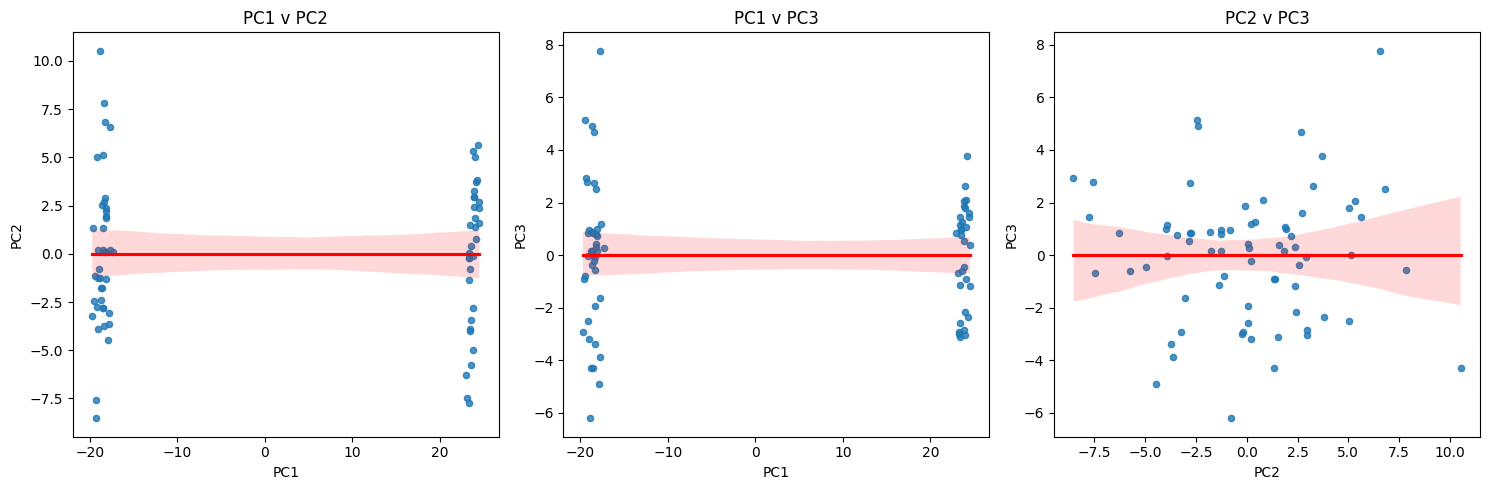

In [647]:
import seaborn as sns
import matplotlib.pyplot as plt

X_train_pca_df = pd.DataFrame(X_train_pca, columns=['PC1', 'PC2', 'PC3'])
X_train_pca_df['Y'] = y_train_no_outliers.copy()

fig, axes = plt.subplots(1, 3, figsize=(15,5))

sns.regplot(x='PC1', y='PC2', data=X_train_pca_df,scatter_kws={'s': 20}, line_kws={'color':'red'}, ax = axes[0])
sns.regplot(x='PC1', y='PC3', data=X_train_pca_df,scatter_kws={'s': 20}, line_kws={'color':'red'}, ax = axes[1])
sns.regplot(x='PC2', y='PC3', data=X_train_pca_df,scatter_kws={'s': 20}, line_kws={'color':'red'}, ax = axes[2])

axes[0].set_title('PC1 v PC2')
axes[1].set_title('PC1 v PC3')
axes[2].set_title('PC2 v PC3')

plt.tight_layout()

plt.show()

De los datos del PCA, podemos ver que el primer componente es el que explica la mayor varianza, por sobre el 90%. También de la gráfica se puede observar que la línea de regresión se encuentra cercano a 0 en todos los gráficso, lo que indica que es muy probable que no hay una correlación entre los componentes del PCA.

## Modelamiento



In [648]:
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score

#We have to apply the same transformations we applied to the training data
#These are: zscore, and pca transform.
X_test_pca = pca.transform(zscore(X_test))

svr = SVR(kernel='rbf')
svr.fit(X_train_pca, y_train_no_outliers)

rf = RandomForestRegressor()
rf.fit(X_train_pca, y_train_no_outliers)

lin = LinearRegression()
lin.fit(X_train_pca, y_train_no_outliers)

degree = 2
poly = make_pipeline(PolynomialFeatures(degree), LinearRegression())
poly.fit(X_train_pca, y_train_no_outliers)


Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])

R2 (SVR): 0.237059604170286, Standard Deviation: 0.2511783783803655
R2 (Random Forest): 0.01802983845281676, Standard Deviation: 0.44561822856118133
R2 (Linear): 0.25363561919426036, Standard Deviation: 0.22981115839421964

R2 (Poly-2): 0.26121210479523005, Standard Deviation: 0.2604946139397312



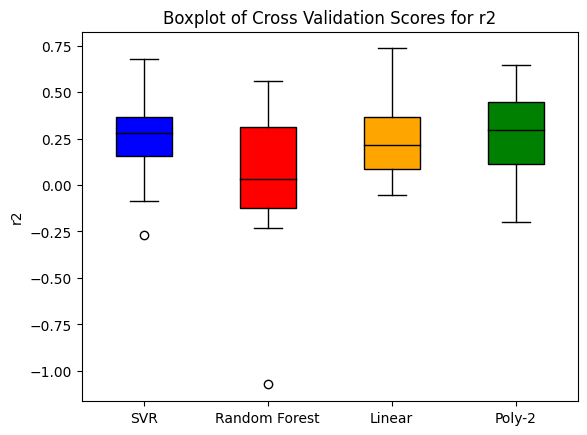

Neg_mean_squared_error (SVR): -2.4479832455350197, Standard Deviation: 1.3506865186695045
Neg_mean_squared_error (Random Forest): -2.853508915588889, Standard Deviation: 1.2410039900290528
Neg_mean_squared_error (Linear): -2.369809696323587, Standard Deviation: 1.2152608501414586

Neg_mean_squared_error (Poly-2): -2.2934154681414065, Standard Deviation: 1.2754852456918133



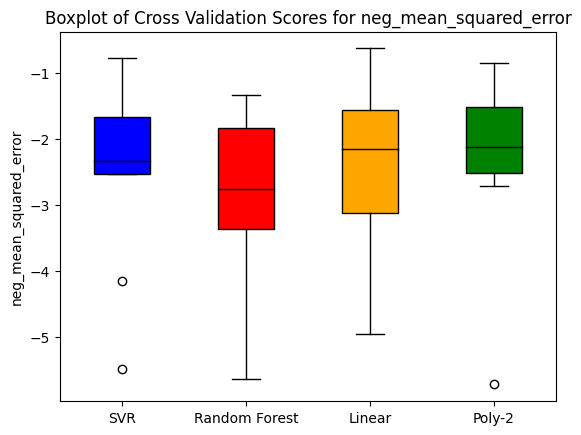

Neg_root_mean_squared_error (SVR): -1.5076971732678286, Standard Deviation: 0.41812973974021345
Neg_root_mean_squared_error (Random Forest): -1.6508521524986457, Standard Deviation: 0.358044810295411
Neg_root_mean_squared_error (Linear): -1.4864279636762727, Standard Deviation: 0.40042677873088883

Neg_root_mean_squared_error (Poly-2): -1.4663093069685487, Standard Deviation: 0.37861918128750555



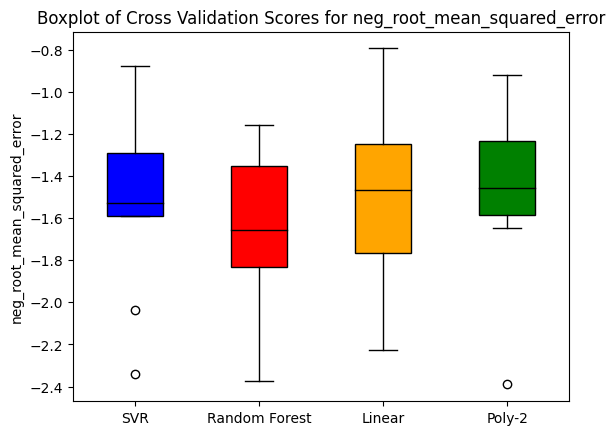

Explained_variance (SVR): 0.28361742043190674, Standard Deviation: 0.23643437685795077
Explained_variance (Random Forest): 0.08173574197720648, Standard Deviation: 0.4320963752444404
Explained_variance (Linear): 0.2830252229008754, Standard Deviation: 0.2276605147058477

Explained_variance (Poly-2): 0.30964124893413414, Standard Deviation: 0.22765635785251523



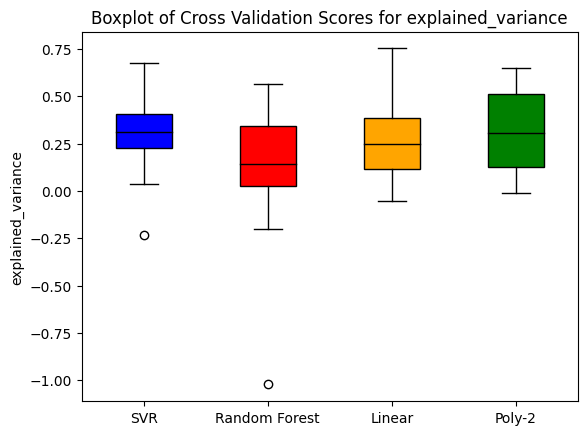

In [650]:
from sklearn.model_selection import cross_validate, KFold
from sklearn.metrics import explained_variance_score
import numpy as np

kfold = KFold(n_splits=10, shuffle=True, random_state=42)
X_combined = np.vstack((X_train_pca, X_test_pca))
y_combined = np.concatenate((y_train_no_outliers, y_test))

scoring_metrics = ['r2', 'neg_mean_squared_error', 'neg_root_mean_squared_error', 'explained_variance']
scores_svr = cross_validate(svr, X_combined, y_combined, cv=kfold, scoring=scoring_metrics)
scores_rf = cross_validate(rf, X_combined, y_combined, cv=kfold, scoring=scoring_metrics)
scores_lin = cross_validate(lin, X_combined, y_combined, cv=kfold, scoring=scoring_metrics)
scores_poly2 = cross_validate(poly, X_combined, y_combined, cv=kfold, scoring=scoring_metrics)

for metric in scoring_metrics:
    print(f"{metric.capitalize()} (SVR): {np.mean(scores_svr[f'test_{metric}'])}, "
          f"Standard Deviation: {np.std(scores_svr[f'test_{metric}'])}")
    print(f"{metric.capitalize()} (Random Forest): {np.mean(scores_rf[f'test_{metric}'])}, "
          f"Standard Deviation: {np.std(scores_rf[f'test_{metric}'])}")
    print(f"{metric.capitalize()} (Linear): {np.mean(scores_lin[f'test_{metric}'])}, "
          f"Standard Deviation: {np.std(scores_lin[f'test_{metric}'])}\n")
    print(f"{metric.capitalize()} (Poly-2): {np.mean(scores_poly2[f'test_{metric}'])}, "
          f"Standard Deviation: {np.std(scores_poly2[f'test_{metric}'])}\n")

    scores_metric_svr = scores_svr[f'test_{metric}']
    scores_metric_rf = scores_rf[f'test_{metric}']
    scores_metric_poly2 = scores_poly2[f'test_{metric}']
    scores_metric_linear = scores_lin[f'test_{metric}']

    colors = ['blue', 'red', 'orange', 'green']
    boxes = plt.boxplot([scores_metric_svr, scores_metric_rf, scores_metric_linear, scores_metric_poly2],
                        labels=['SVR', 'Random Forest', 'Linear', 'Poly-2'], patch_artist=True)
    for patch, color in zip(boxes['boxes'], colors):
      patch.set_facecolor(color)
    for median in boxes['medians']:
      median.set_color('black')

    plt.ylabel(metric)
    plt.title(f'Boxplot of Cross Validation Scores for {metric}')
    plt.show()

R2 Score (SVR): 0.14491148604025594
Mean Squared Error Score (SVR): 5.108222037609217
Root Mean Squared Error Score (SVR): 2.260137614750309
Explained variance (SVR): 0.3077937547945553

R2 Score (Random Forest): 0.19371107241200602
Mean Squared Error (Random Forest): 4.816697688421053
Root Mean Squared Error (Random Forest): 2.194697630294673
Explained variance (Random Forest): 0.2787389303701747

R2 Score (Linear Regression): -0.16794871885342455
Mean Squared Error (Linear Regression): 6.977220822224012
Root Mean Squared Error (Linear Regression): 2.641442943208127
Explained variance (Linear Regression): -0.041094441695537665

R2 Score (Poly-2): -0.23877030765773188
Mean Squared Error (Poly-2): 7.400302637454304
Root Mean Squared Error (Poly-2): 2.7203497270487675
Explained variance (Poly-2): -0.1674952531542775



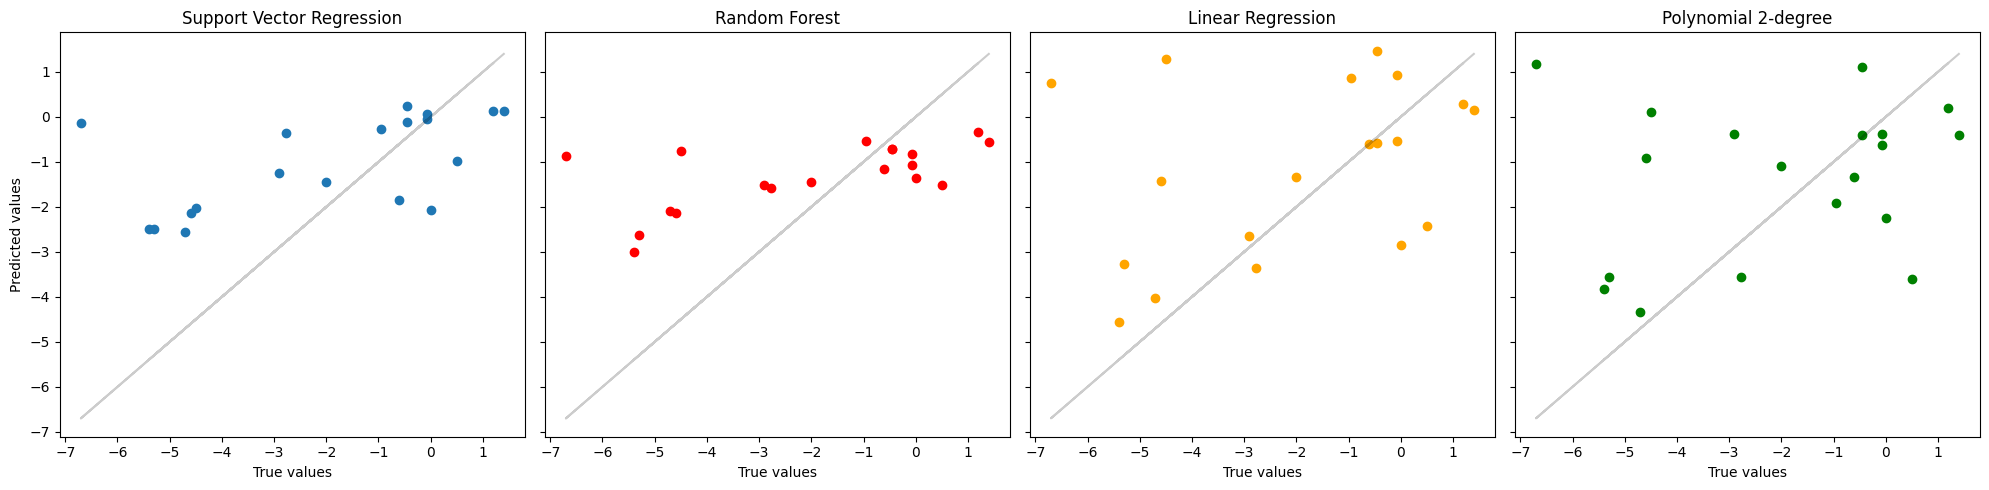

In [644]:
y_pred = svr.predict(X_test_pca)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
e_v = explained_variance_score(y_test, y_pred)

print(f'R2 Score (SVR): {r2}')
print(f'Mean Squared Error Score (SVR): {mse}')
print(f'Root Mean Squared Error Score (SVR): {rmse}')
print(f'Explained variance (SVR): {e_v}\n')


y_pred_rf = rf.predict(X_test_pca)
r2_rf = r2_score(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = mean_squared_error(y_test, y_pred_rf, squared=False)
e_v_rf = explained_variance_score(y_test, y_pred_rf)
print(f'R2 Score (Random Forest): {r2_rf}')
print(f'Mean Squared Error (Random Forest): {mse_rf}')
print(f'Root Mean Squared Error (Random Forest): {rmse_rf}')
print(f'Explained variance (Random Forest): {e_v_rf}\n')

y_pred_l = lin.predict(X_test_pca)
r2_l = r2_score(y_test, y_pred_l)
mse_l = mean_squared_error(y_test, y_pred_l)
rmse_l = mean_squared_error(y_test, y_pred_l, squared=False)
e_v_l = explained_variance_score(y_test, y_pred_l)
print(f'R2 Score (Linear Regression): {r2_l}')
print(f'Mean Squared Error (Linear Regression): {mse_l}')
print(f'Root Mean Squared Error (Linear Regression): {rmse_l}')
print(f'Explained variance (Linear Regression): {e_v_l}\n')

y_pred_p2 = poly.predict(X_test_pca)
r2_p2 = r2_score(y_test, y_pred_p2)
mse_p2 = mean_squared_error(y_test, y_pred_p2)
rmse_p2 = mean_squared_error(y_test, y_pred_p2, squared=False)
e_v_p2 = explained_variance_score(y_test, y_pred_p2)
print(f'R2 Score (Poly-2): {r2_p2}')
print(f'Mean Squared Error (Poly-2): {mse_p2}')
print(f'Root Mean Squared Error (Poly-2): {rmse_p2}')
print(f'Explained variance (Poly-2): {e_v_p2}\n')



fig, axs = plt.subplots(1, 4, figsize=(20, 5), sharey=True)

#plt.scatter(X_test, y_test, label = 'True values', color='blue')
axs[0].scatter(y_test, y_pred, label = "SVR")
axs[0].plot(y_test, y_test, color = 'black', alpha=0.2)
axs[0].set_title("Support Vector Regression")
axs[0].set_xlabel("True values")
axs[0].set_ylabel("Predicted values")

axs[1].scatter(y_test, y_pred_rf, label = "Random Forest", color = "red")
axs[1].set_title("Random Forest")
axs[1].plot(y_test, y_test, color = 'black', alpha=0.2)
axs[1].set_xlabel("True values")

axs[2].scatter(y_test, y_pred_l, label = "Linear Regression", color = "orange")
axs[2].set_title("Linear Regression")
axs[2].plot(y_test, y_test, color = 'black', alpha=0.2)
axs[2].set_xlabel("True values")


axs[3].scatter(y_test, y_pred_p2, label = "Polynomial 2-degree", color = "green")
axs[3].set_title("Polynomial 2-degree")
axs[3].plot(y_test, y_test, color = 'black', alpha=0.2)
axs[3].set_xlabel("True values")
#axs[1].set_ylabel("Predicted values")

plt.tight_layout()
plt.show()